<a href="https://colab.research.google.com/github/linpohan/mask_detect/blob/main/face%26mask.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install facemask-detection
!pip install -U retinaface_pytorch

     |████████████████████████████████| 376 kB 5.9 MB/s 
     |████████████████████████████████| 631 kB 44.4 MB/s 
  Created wheel for imgaug: filename=imgaug-0.2.6-py3-none-any.whl size=654020 sha256=5afe0686a611f1226b0ed1c9101bf3fbb65c5233171c08be8c552839da2fd268
  Stored in directory: /root/.cache/pip/wheels/89/72/98/3ebfdba1069a9a8eaaa7ae7265cfd67d63ef0197aaee2e5f9c
Successfully built imgaug
  Attempting uninstall: imgaug
    Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
     |████████████████████████████████| 64 kB 2.0 MB/s 
     |████████████████████████████████| 9.1 MB 25.8 MB/s 
     |████████████████████████████████| 2.1 MB 52.6 MB/s 
     |████████████████████████████████| 111 kB 55.1 MB/s 
     |████████████████████████████████| 180 kB 35.1 MB/s 
     |████████████████████████████████| 4.3 MB 35.3 MB/s 
     |████████████████████████████████| 178 kB 66.9 MB/s 
     |████████████████████████████████| 76 kB

In [2]:
from facemask_detection.pre_trained_models import get_model as get_classifier
import cv2
import albumentations as A
import torch
import numpy as np
import matplotlib.pyplot as plt
from retinaface.pre_trained_models import get_model as get_detector

In [3]:
from tqdm import tqdm

In [48]:
image = cv2.imread("/content/drive/MyDrive/Colab Notebooks/LCC/facemask3.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

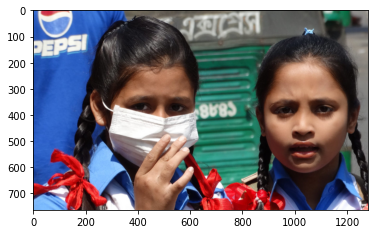

In [49]:
plt.imshow(image)

In [50]:
face_detector = get_detector("resnet50_2020-07-20", max_size=800)
face_detector.eval()
with torch.no_grad():
  annotations = face_detector.predict_jsons(image)
len(annotations)

/usr/local/lib/python3.7/dist-packages/torch/hub.py:513: UserWarning: Falling back to the old format < 1.6. This support will be deprecated in favor of default zipfile format introduced in 1.6. Please redo torch.save() to save it in the new zipfile format.
  warnings.warn('Falling back to the old format < 1.6. This support will be '


2

In [51]:
print(annotations)

[{'bbox': [886, 203, 1201, 625], 'score': 0.9999240636825562, 'landmarks': [[965, 384], [1104, 377], [1035, 460], [986, 532], [1092, 525]]}, {'bbox': [292, 182, 616, 630], 'score': 0.9997308850288391, 'landmarks': [[414, 373], [551, 364], [500, 456], [432, 523], [533, 520]]}]


In [52]:
model = get_classifier("tf_efficientnet_b0_ns_2020-07-29")
model.eval()

/usr/local/lib/python3.7/dist-packages/torch/hub.py:513: UserWarning: Falling back to the old format < 1.6. This support will be deprecated in favor of default zipfile format introduced in 1.6. Please redo torch.save() to save it in the new zipfile format.
  warnings.warn('Falling back to the old format < 1.6. This support will be '


Sequential(
  (0): EfficientNet(
    (conv_stem): Conv2dSame(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (act1): SiLU(inplace=True)
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (act1): SiLU(inplace=True)
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn2): BatchNorm2d(16, eps=0.001, momentum=0.1, affine=True, track_running_s

In [53]:
transform = A.Compose([A.SmallestMaxSize(max_size=256, p=1), # 等比縮放, 最小邊長256
                       A.CenterCrop(height=224,width=224, p=1), # 中心點裁切
                       A.Normalize(p=1)])

In [72]:
predictions = []

with torch.no_grad():
  for annotation in tqdm(annotations):
    x_min, y_min, x_max, y_max = annotation['bbox']

    x_min = np.clip(x_min, 0, x_max)
    y_min = np.clip(y_min, 0, y_max)
    
    crop = image[y_min:y_max, x_min:x_max]
    
    crop_transformed = transform(image=crop)['image']
    model_input = torch.from_numpy(np.transpose(crop_transformed, (2, 0, 1))).unsqueeze(0)
    
    predictions.append(model(model_input)[0].item())
    

100%|██████████| 2/2 [00:00<00:00, 14.58it/s]


In [73]:
predictions

[0.7717640995979309, 1.0]

In [76]:
vis_image = image.copy()

for prediction_id, annotation in enumerate(annotations):
    is_mask = predictions[prediction_id]
    if is_mask > 0.8:
      color = (255, 0, 0)    
      text = "mask"
    else:
      color = (0, 255, 0)
      text = "no mask"

    x_min, y_min, x_max, y_max = annotation["bbox"]
    x_min = np.clip(x_min, 0, x_max - 1)
    y_min = np.clip(y_min, 0, y_max - 1)

    vis_image = cv2.rectangle(vis_image, (x_min, y_min), (x_max, y_max), color=color, thickness=2)
    vis_image = cv2.putText(vis_image, text, (x_min, y_min - 10), cv2.FONT_HERSHEY_SIMPLEX,  1, color, 2, cv2.LINE_AA) 

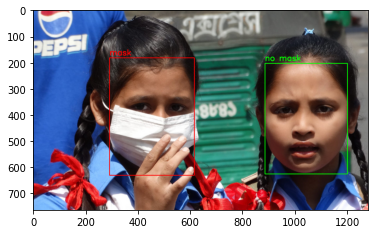

In [75]:
plt.imshow(vis_image)